In [1]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import datetime
import matplotlib.dates as mdates

Populating the interactive namespace from numpy and matplotlib


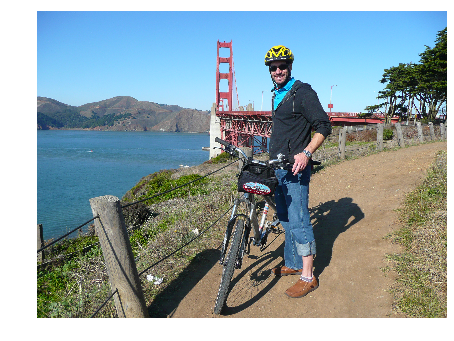

In [2]:
im = plt.imread('Mike.jpg')
implot = plt.imshow(im)
plt.axis("off")
plt.show()

## Meet Mike. 
## He just moved to San Francisco after accepting a new job. Mike is a bike enthusiast who does not accept any way of transportation other then a bike. He has heard that SF isn't the most safe place to park a bike, so he is determent to use famous Bay Area Bike Share service.
## The goal for this story is to hepl Mike to get best experience of using the bike service

### For starter, let's prepare the data

In [3]:
#load and aggragete data
tripDf=pd.read_csv('201402_trip_data.csv').append(pd.read_csv('201408_trip_data.csv')).append(pd.read_csv('201508_trip_data.csv'))
statusDf=pd.read_csv('201402_status_data.csv').append(pd.read_csv('201408_status_data.csv')).append(pd.read_csv('201508_status_data.csv'))
stationsDf=pd.read_csv('201402_station_data.csv').append(pd.read_csv('201408_station_data.csv')).append(pd.read_csv('201508_station_data.csv'))
#filter the data keeping only bike stations loketed
stationsDf=stationsDf[stationsDf.landmark=='San Francisco']
stationsList=stationsDf.station_id.tolist()
tripDf=tripDf[tripDf['Start Terminal'].isin(stationsList)]
statusDf=statusDf[statusDf.station_id.isin(stationsList)]

### Now, let's look what we have

In [4]:
stationsDf.head(3)

,station_id,name,lat,long,dockcount,landmark,installation
32,39,Powell Street BART,37.783871,-122.408433,19,San Francisco,8/25/2013
33,41,Clay at Battery,37.795001,-122.399970,15,San Francisco,8/19/2013
34,42,Davis at Jackson,37.797280,-122.398436,15,San Francisco,8/19/2013


In [5]:
tripDf.head(3)

,Bike #,Duration,End Date,End Station,End Terminal,Start Date,Start Station,Start Terminal,Subscriber Type,Subscription Type,Trip ID,Zip Code
0,520,63,8/29/2013 14:14,South Van Ness at Market,66,8/29/2013 14:13,South Van Ness at Market,66,NaN,Subscriber,4576,94127
4,319,83,8/29/2013 12:04,Market at 10th,67,8/29/2013 12:02,South Van Ness at Market,66,NaN,Subscriber,4299,94103
5,527,103,8/29/2013 18:56,Golden Gate at Polk,59,8/29/2013 18:54,Golden Gate at Polk,59,NaN,Subscriber,4927,94109


In [6]:
statusDf.head(3)

,station_id,bikes_available,docks_available,time
7985991,41,9,6,2013/08/29 12:06:01
7985992,41,9,6,2013/08/29 12:07:01
7985993,41,8,7,2013/08/29 12:08:01


## It will be helpful for Mike to know where bike stations are located and how popular each of them

#### By the way he can  shared his home and work adress

In [7]:
work=(-122.39,37.779)
home=(-122.406,37.7888)

In [8]:
rentalsDf=pd.DataFrame(tripDf.groupby('Start Terminal').size(), columns=['Rentals'])#Get number of pickups from each station
stationsDf.set_index('station_id', inplace=True)
finDf=rentalsDf.merge(stationsDf[['lat','long']], left_index=True,right_index=True)# Put together number of rentals and location
finDf.drop_duplicates('Rentals',inplace=True)# there two stations that changed locketion a little bit, so let's keep one location

In [9]:
#Prepare data for a map
lats=finDf.lat.tolist()
longs=finDf.long.tolist()
sumRentals=finDf.Rentals.sum()
sizes=[x*1000/sumRentals for x in finDf.Rentals.tolist()]# create list of sizes based on share rentals from one station in totall rentals in SF

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1827290.462973907,640534.7519022719,1834494.9201700795,648157.4788812463&bboxSR=2768&imageSR=2768&size=1500,1587&dpi=96&format=png32&f=image


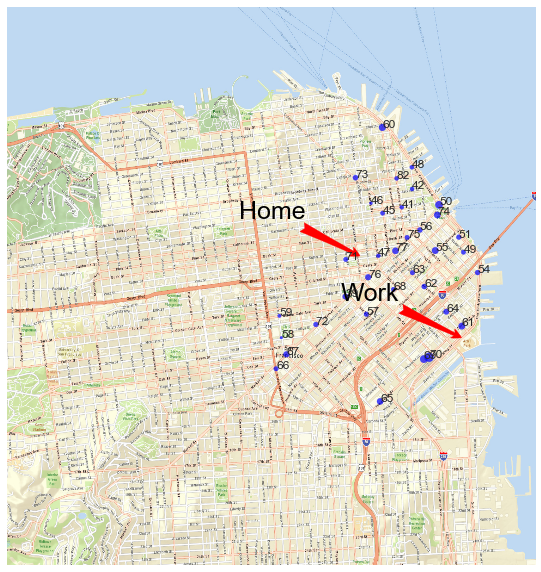

In [10]:
plt.figure(figsize=(13,10))
map = Basemap(llcrnrlon=-122.460,llcrnrlat=37.75,urcrnrlon=-122.380,urcrnrlat=37.820, epsg=2768)
#http://server.arcgisonline.com/arcgis/rest/services
x,y =map(longs,lats)
map.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1500, verbose= True)
map.scatter(x,y,marker="o",color='b',s=sizes,alpha=0.7)

#add annotation
xH,yH =map(home[0],home[1])

plt.annotate('Home', xy=(xH, yH),  xycoords='data',
                xytext=(home[0],home[1]), textcoords='offset points',
                color='black',size=25,
                arrowprops=dict(arrowstyle="fancy", color='r'))

xW,yW =map(work[0],work[1])

plt.annotate('Work', xy=(xW,yW),  xycoords='data',
                xytext=(work[0],work[1]), textcoords='offset points',
                color='black',size=25,
                arrowprops=dict(arrowstyle="fancy", color='r'))
#add Labels
labels = finDf.index.tolist()
for label, xpt, ypt in zip(labels, x, y):
    plt.text(xpt, ypt, label)
plt.show()

## Now, when Mike knows where stations are located, he might want to consider what stations are infoumes for beeing empty relativly often. 

In [11]:
statusDfBikes=statusDf[statusDf.bikes_available==0]# select one mitute increments when stations had no bikes
missingsDf=pd.DataFrame(statusDfBikes.groupby('station_id').size(), columns=['Missings']).reset_index() # get number of 'empty' mitutes for each station
print ('Mean: ', missingsDf.Missings.mean())
print ('STD: ', missingsDf.Missings.std())

Mean:  12980.6
STD:  7085.729528632968


In [12]:
# function that creates colores based on realative performance of a station 
def classif(x,avg=12980, std=7085):
    if x<=avg-std:
        return "springgreen" #Very good
    elif x<=avg:
        return "green" # Good
    elif x>avg+std:
        return "darkorange" # Not so good
    elif x>(avg):
        return "red" # Bad

In [13]:
missingsDf['colorBike']=missingsDf.Missings.apply(classif)# add color
missingsDf.set_index('station_id', inplace=True)
finDf=finDf.merge(missingsDf[['colorBike']], left_index=True,right_index=True)# megre location data

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1827290.462973907,640534.7519022719,1834494.9201700795,648157.4788812463&bboxSR=2768&imageSR=2768&size=1500,1587&dpi=96&format=png32&f=image


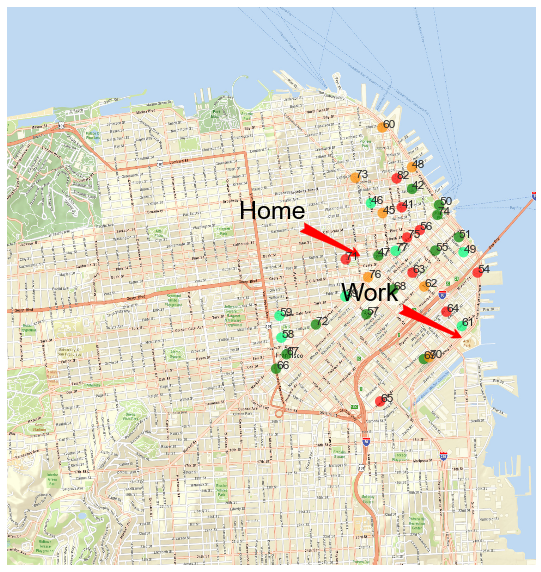

In [14]:
plt.figure(figsize=(13,10))
map = Basemap(llcrnrlon=-122.460,llcrnrlat=37.75,urcrnrlon=-122.380,urcrnrlat=37.820, epsg=2768)
#http://server.arcgisonline.com/arcgis/rest/services
x,y =map(longs,lats)
map.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1500, verbose= True)
map.scatter(x,y,marker="o",color=finDf['colorBike'].tolist(),s=100,alpha=0.7)

xH,yH =map(home[0],home[1])

plt.annotate('Home', xy=(xH, yH),  xycoords='data',
                xytext=(home[0],home[1]), textcoords='offset points',
                color='black',size=25,
                arrowprops=dict(arrowstyle="fancy", color='r'))

xW,yW =map(work[0],work[1])

plt.annotate('Work', xy=(xW,yW),  xycoords='data',
                xytext=(work[0],work[1]), textcoords='offset points',
                color='black',size=25,
                arrowprops=dict(arrowstyle="fancy", color='r'))

labels = finDf.index.tolist()
for label, xpt, ypt in zip(labels, x, y):
    plt.text(xpt, ypt, label)
plt.show()

## Now, let's find out where it might be challenging to drop a bike

In [15]:
statusDfDocks=statusDf[statusDf.docks_available==0]
missingsDf=pd.DataFrame(statusDfDocks.groupby('station_id').size(), columns=['Missings']).reset_index()
print (missingsDf.Missings.mean())
print (missingsDf.Missings.std())

7608.085714285714
6979.699649578006


In [16]:
# redefine a classificator
def classif(x,avg=7608, std=6979):
    if x<=avg-std:
        return "springgreen"
    elif x<=avg:
        return "green"
    elif x>avg+std:
        return "darkorange"
    elif x>(avg):
        return "red"

In [17]:
missingsDf['ColorDocs']=missingsDf.Missings.apply(classif)
missingsDf.set_index('station_id', inplace=True)
finDf=finDf.merge(missingsDf[['ColorDocs']], left_index=True,right_index=True)

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1827290.462973907,640534.7519022719,1834494.9201700795,648157.4788812463&bboxSR=2768&imageSR=2768&size=1500,1587&dpi=96&format=png32&f=image


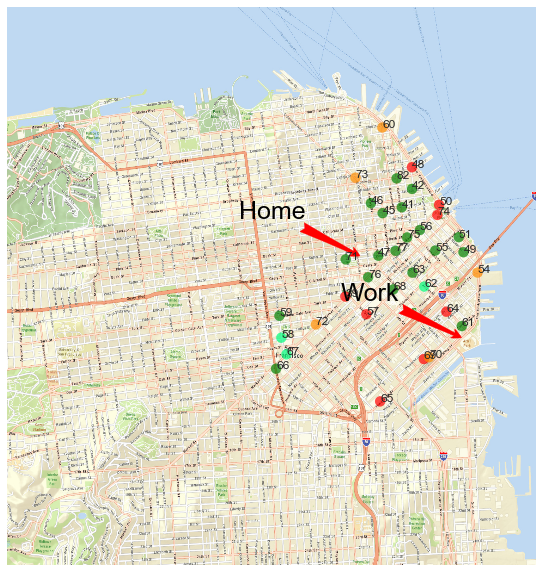

In [18]:
plt.figure(figsize=(13,10))
map = Basemap(llcrnrlon=-122.460,llcrnrlat=37.75,urcrnrlon=-122.380,urcrnrlat=37.820, epsg=2768)
#http://server.arcgisonline.com/arcgis/rest/services
x,y =map(longs,lats)
map.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1500, verbose= True)
map.scatter(x,y,marker="o",color=finDf['ColorDocs'].tolist(),s=100,alpha=0.7)

xH,yH =map(home[0],home[1])

plt.annotate('Home', xy=(xH, yH),  xycoords='data',
                xytext=(home[0],home[1]), textcoords='offset points',
                color='black',size=25,
                arrowprops=dict(arrowstyle="fancy", color='r'))

xW,yW =map(work[0],work[1])

plt.annotate('Work', xy=(xW,yW),  xycoords='data',
                xytext=(work[0],work[1]), textcoords='offset points',
                color='black',size=25,
                arrowprops=dict(arrowstyle="fancy", color='r'))

labels = finDf.index.tolist()
for label, xpt, ypt in zip(labels, x, y):
    plt.text(xpt, ypt, label)
plt.show()

## Now Mike knows where are good stations and were it might be realativly challenging take/drop a bike in general. 

## Tomorrow Mike has his first day at  job and the last thing  he needs is beeing late. There are three stations near his home (71,76,47) and two stations near his work (64 and 61). To make a dicision regarding a station, he need to know: 
## what are the chances that each of three stations next to his home has at leat 5 available bikes at 7.30 am during working day
## what are the chances that each of two stations next to his work has at leat 5 available dock at 7.50 am during working day

In [22]:
homeStations=[71,76,47]
statusHomeDf=statusDf[statusDf.station_id.isin(homeStations)]
statusHomeDf=statusHomeDf[statusHomeDf.bikes_available<5]
statusHomeDf['time']=pd.DatetimeIndex(statusHomeDf['time']).to_datetime()
statusHomeDf=statusHomeDf[(statusHomeDf['time'].dt.hour==7) & (statusHomeDf['time'].dt.minute==30)]
1-statusHomeDf.groupby('station_id').size()/(2*52*5)

station_id
47    0.584615
71    0.836538
76    0.659615
dtype: float64

## It turns out that the best station to pick up a bike at 7.30 on a work day is station 71. Over last two years this station had at least five available bikes a 7.30 in 84% of working day. It is quite intresting finging because if we look at bike avaibility on general, station 47 did look more promissing than other stations, but in this analysis showed the worst result.

In [20]:
workStations=[64,61]
statusWorkDf=statusDf[statusDf.station_id.isin(workStations)]
statusWorkDf=statusWorkDf[statusWorkDf.docks_available<5]
statusWorkDf['time']=pd.DatetimeIndex(statusWorkDf['time']).to_datetime()
statusWorkDf=statusWorkDf[(statusWorkDf['time'].dt.hour==7) & (statusWorkDf['time'].dt.minute==50)]
1-statusWorkDf.groupby('station_id').size()/(2*52*5)

station_id
61    0.955769
64    0.915385
dtype: float64

## It will be quite easy for Mike to drop a bike. There are more than 90% chances to see at least five free docks at either of two stations.